In [1]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist_dataset_train = MNIST('train', True, download=True)
mnist_dataset_test = MNIST('test', False, download=True)

In [3]:
 len(mnist_dataset_train), len(mnist_dataset_test)

(60000, 10000)

In [4]:
mnist_dataset_train[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1C64796EC10>, 5)

<ipython-input-4-760f049859f5>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


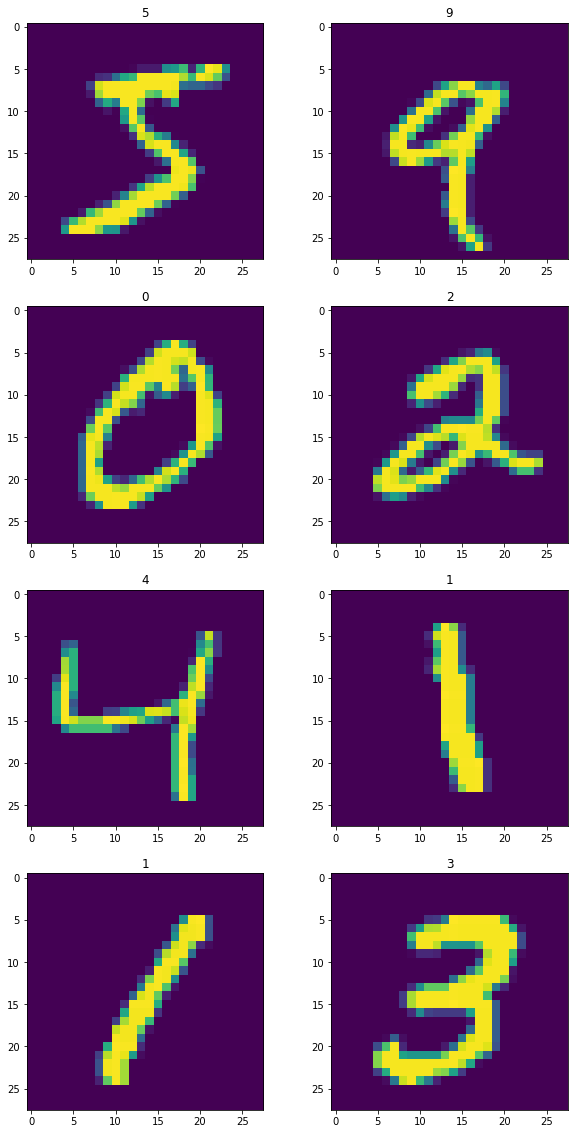

In [4]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))

for idx, (x, y) in enumerate(mnist_dataset_train):
    ax = axs[idx % 4][idx // 4]
    ax.imshow(x)
    ax.set_title(y)
    if idx == 7:
        break
fig.show()

In [5]:
np.array(mnist_dataset_train[0][0]).reshape(784).shape

(784,)

In [6]:
np.array([el[1] for el in mnist_dataset_train])

array([5, 0, 4, ..., 5, 6, 8])

In [7]:
X_train = np.array([np.array(el[0]).flatten() for el in mnist_dataset_train])
y_train = np.array([el[1] for el in mnist_dataset_train])
X_test = np.array([np.array(el[0]).flatten() for el in mnist_dataset_test])
y_test = np.array([el[1] for el in mnist_dataset_test])

In [8]:
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train[:2000], y_train[:2000])

LogisticRegression(max_iter=10000)

In [15]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [16]:
accuracy_train = np.sum(y_train == y_pred_train)/len(y_train)
accuracy_test = np.sum(y_test == y_pred_test)/len(y_test)

print(f'{accuracy_train=}, {accuracy_test=}')

accuracy_train=0.8589, accuracy_test=0.8597


In [17]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import AdamW

from tqdm import tqdm

from IPython.display import clear_output

In [18]:
mnist_dataset_train = MNIST('train', True, download=True, transform=ToTensor())
mnist_dataset_test = MNIST('test', False, download=True, transform=ToTensor())

In [19]:
type(mnist_dataset_test[0][0]), type(mnist_dataset_test[0][1]), mnist_dataset_test[0][0].shape

(torch.Tensor, int, torch.Size([1, 28, 28]))

In [20]:
batch_size = 32
train_dataloader = DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=False)

In [21]:
for el in train_dataloader:
    print(len(el), el[0].shape, el[1])
    break

2 torch.Size([32, 1, 28, 28]) tensor([6, 6, 6, 2, 1, 0, 1, 2, 6, 0, 6, 8, 8, 7, 8, 1, 3, 2, 2, 1, 9, 9, 7, 5,
        6, 0, 2, 9, 8, 6, 2, 7])


In [22]:
el[0].max()

tensor(1.)

In [24]:
class Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.fc1 = nn.Linear(4 * 4 * 64, 10) 
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

In [25]:
model = Mnist()
x = torch.zeros(1, 1, 28, 28)
y = model(x)
y.shape

torch.Size([1, 10])

In [26]:
def train(model, criterion, optimizer, dataloader, max_num_batches=1000):
    total_loss = 0
    total_accuracy = 0
    model.train()
    for idx, batch in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        x, y = batch[0], batch[1]
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += np.sum(np.argmax(pred.detach().numpy(), axis=1) == y.detach().numpy()) / len(batch[0])
        if idx == max_num_batches:
            break
    return total_loss / max_num_batches, total_accuracy / max_num_batches


In [27]:
def test(model, criterion, optimizer, dataloader):
    total_loss = 0
    total_accuracy = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(dataloader)):
            x, y = batch[0], batch[1]
            with torch.no_grad():
                pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            total_accuracy += np.sum(np.argmax(pred.detach().numpy(), axis=1) == y.detach().numpy()) / len(batch[0])
    return total_loss / len(dataloader), total_accuracy / len(dataloader)

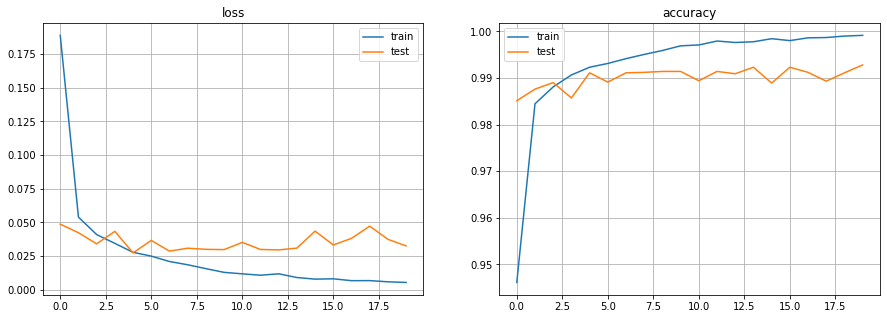

Max accuracy on test: 0.9928115015974441


In [28]:
model = Mnist()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters())

total_train_loss = []
total_test_loss = []
total_train_accuracy = []
total_test_accuracy = []

for epoch in range(20):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_dataloader)
    test_loss, test_accuracy = test(model, criterion, optimizer, test_dataloader)

    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)
    total_train_accuracy.append(train_accuracy)
    total_test_accuracy.append(test_accuracy)

    clear_output(True)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(total_train_loss, label='train')
    axs[0].plot(total_test_loss, label='test')
    axs[0].set_title('loss')
    axs[0].grid()
    axs[0].legend(loc='best')


    axs[1].plot(total_train_accuracy, label='train')
    axs[1].plot(total_test_accuracy, label='test')
    axs[1].set_title('accuracy')
    axs[1].grid()
    axs[1].legend(loc='best')

    plt.show()

max_accuracy = max(total_test_accuracy)
print('Max accuracy on test:', max_accuracy)

In [29]:
print(f"Кол-во параметров: {sum(p.numel() for p in model.parameters())}.")

Кол-во параметров: 62346.
